# Uniform Manifold Approximation and Projection (UMAP)

UMAP é um algoritmo de redução de dimensionalidade e visualização de dados que se destaca na preservação tanto da estrutura local quanto da estrutura global dos dados. Baseado em fundamentos da geometria Riemanniana e topologia algébrica, o UMAP constrói uma representação topológica dos dados em alta dimensão e, em seguida, busca otimizar um embedding de baixa dimensão que seja o mais estruturalmente equivalente possível. Este notebook explora os conceitos fundamentais do UMAP e implementa uma versão simplificada do algoritmo para fins didáticos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import NearestNeighbors

# Configurações de plotagem
plt.style.use('seaborn-v0_8-whitegrid')

### Geração de Dados Sintéticos

Para visualizar a eficácia do UMAP, utilizaremos um conjunto de dados sintético conhecido como "Swiss Roll". Este dataset é um exemplo clássico de um manifold não linear em três dimensões, onde os pontos seguem uma estrutura espiralada. O objetivo será "desenrolar" este manifold em um espaço bidimensional.

In [2]:
# Gerar o dataset Swiss Roll
n_samples = 1500
noise = 0.05
X, color = make_swiss_roll(n_samples, noise=noise, random_state=42)

# Normalizar os dados
X = (X - np.min(X)) / (np.max(X) - np.min(X))

### Visualização do Manifold Original

Abaixo, plotamos o dataset em seu espaço tridimensional original. As cores representam a posição intrínseca ao longo do manifold, o que nos ajudará a avaliar se a estrutura foi corretamente preservada após a redução de dimensionalidade.

In [ ]:
# Plotar o Swiss Roll em 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Manifold Original do Swiss Roll")
ax.view_init(elev=10., azim=-80)
plt.show()

## Fundamentos Teóricos do UMAP

O UMAP assume que os dados são amostrados de uma variedade Riemanniana (manifold) e que as distâncias entre os pontos na variedade podem ser aproximadas localmente. A partir dessa premissa, o algoritmo opera em duas fases principais: a construção de uma representação topológica dos dados em alta dimensão e a otimização de um layout de baixa dimensão que preserve essa topologia.

### Construção do Grafo de Alta Dimensão

A primeira etapa do UMAP consiste em construir um grafo ponderado que represente a estrutura topológica dos dados originais. Para cada ponto de dados $x_i$, o algoritmo identifica seus $k$ vizinhos mais próximos. A ponderação das arestas deste grafo não é meramente a distância, mas sim uma probabilidade de conexão baseada em uma métrica localmente adaptativa.

Para cada ponto $x_i$, uma métrica local é estabelecida ao encontrar um valor $\sigma_i$ tal que a soma das probabilidades de seus vizinhos some um valor constante (geralmente $\log_2(k)$). A probabilidade condicional $p_{j|i}$ de que $x_j$ esteja conectado a $x_i$ é dada por:

$$p_{j|i} = \exp\left(-\frac{d(x_i, x_j) - \rho_i}{\sigma_i}\right)$$

Onde $\rho_i$ é a distância do ponto $x_i$ ao seu vizinho mais próximo. Esta normalização garante que a conectividade seja definida em termos de uma noção local de distância, tornando o algoritmo robusto a variações na densidade dos dados.

As probabilidades condicionais são então simetrizadas para formar a afinidade final $p_{ij}$ no espaço de alta dimensão, através de uma união fuzzy:

$$p_{ij} = p_{j|i} + p_{i|j} - p_{j|i}p_{i|j}$$

Isso resulta em uma matriz de adjacência ponderada que representa um "conjunto simplicial fuzzy" (fuzzy simplicial set), capturando a estrutura topológica do manifold subjacente aos dados.

### Otimização do Embedding de Baixa Dimensão

A segunda fase do UMAP é encontrar uma representação de baixa dimensão dos dados (seja $y_i$ a representação de $x_i$) que melhor se aproxime da estrutura topológica capturada pelo grafo de alta dimensão. Para isso, uma estrutura similar de afinidades, $q_{ij}$, é definida no espaço de baixa dimensão. A função de afinidade utilizada é tipicamente da família ou similar as t-distribuições de Student, o que ajuda a evitar a aglomeração de pontos no centro do embedding e a manter uma separação mais clara entre clusters.

A afinidade $q_{ij}$ entre os pontos $y_i$ e $y_j$ é dada por:

$$q_{ij} = \left(1 + a(y_i - y_j)^{2b}\right)^{-1}$$

Os parâmetros $a$ e $b$ são ajustados para aproximar a forma desejada da distribuição de embedding, geralmente com base nos hiperparâmetros `min_dist` e `spread` do UMAP.

O objetivo da otimização é minimizar a divergência entre as duas distribuições de afinidade, $p_{ij}$ e $q_{ij}$. A função de custo utilizada é a Cross-Entropy (Entropia Cruzada):

$$\text{C(X, Y)} = \sum_{i \neq j} \left[ p_{ij} \log\left(\frac{p_{ij}}{q_{ij}}\right) + (1 - p_{ij}) \log\left(\frac{1 - p_{ij}}{1 - q_{ij}}\right) \right]$$

Esta otimização é realizada através de Stochastic Gradient Descent (SGD), onde arestas do grafo de alta dimensão atuam como forças atrativas e pares de pontos não conectados (amostrados negativamente) atuam como forças repulsivas.

### Implementação Didática do UMAP

A seguir, apresentamos uma classe `UMAP` que implementa as ideias centrais discutidas. Esta implementação é simplificada para fins educacionais e não inclui todas as otimizações de performance (como a busca por vizinhos aproximados ou a amostragem negativa eficiente) encontradas na biblioteca `umap-learn`. O foco é demonstrar o fluxo do algoritmo.

In [ ]:
n = X.shape[0]
knn = NearestNeighbors(n_neighbors=3).fit(X)
dists, inds = knn.kneighbors(X)

rho = dists[:, 1]
sigma = np.zeros(n)

rows = np.repeat(np.arange(n), 3)
cols = inds.flatten()

dist = np.linalg.norm(X[rows] - X[cols], axis=1)
dist = np.maximum(0, dist - rho[rows])
p = np.exp(-dist / (sigma[rows] + 1e-8))

p_matrix = np.zeros((n, n))
p_matrix[rows, cols] = p

p_matrix.shape

In [3]:
class UMAP:
    def __init__(self, n_neighbors=15, n_components=2, n_epochs=200, lr=0.5, random_state=None):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.n_epochs = n_epochs
        self.lr = lr
        self.random_state = np.random.RandomState(random_state)
        self.a, self.b = 1.929, 0.7915  # parâmetros da função de afinidade do UMAP

    def _find_sigma(self, distances, rho):
        """Busca binária para encontrar sigma."""
        target = np.log2(self.n_neighbors)
        low, high = 1e-3, 10.0
        for _ in range(30):
            mid = (low + high) / 2
            psum = np.sum(np.exp(-(np.maximum(0, distances - rho)) / mid))
            if abs(psum - target) < 1e-5:
                return mid
            if psum > target:
                high = mid
            else:
                low = mid
        return mid

    def _build_neighbor_graph(self, X):
        """Etapa 1: constrói o grafo de vizinhança baseado em distâncias."""
        n = X.shape[0]
        
        # Encontra os k vizinhos mais próximos de cada ponto
        knn = NearestNeighbors(n_neighbors=self.n_neighbors).fit(X)
        dists, inds = knn.kneighbors(X)

        # Calcular rho e sigma
        # rho_i: distância mínima não nula (define o raio local de cada ponto)
        # sigma_i: largura da distribuição local (ajustada por busca binária)
        rho = dists[:, 1]
        sigma = np.zeros(n)
        for i in range(n):
            sigma[i] = self._find_sigma(dists[i, 1:], rho[i])

        # Cria pares (i, j) para todas as conexões entre ponto i e seus vizinhos j
        rows = np.repeat(np.arange(n), self.n_neighbors)
        cols = inds.flatten()

        # Calcula distâncias entre cada ponto e seus vizinhos correspondentes
        dist = np.linalg.norm(X[rows] - X[cols], axis=1)

        # Subtrai o raio local rho_i e zera valores negativos
        dist = np.maximum(0, dist - rho[rows])

        # Converte distâncias em probabilidades (função de afinidade exponencial)
        p = np.exp(-dist / (sigma[rows] + 1e-8))

        # União fuzzy (p_ij + p_ji - p_ij*p_ji)
        p_matrix = np.zeros((n, n))
        p_matrix[rows, cols] = p
        p = p_matrix + p_matrix.T - p_matrix * p_matrix.T

        # Extrai apenas pares conectados e normaliza os pesos finais
        rows, cols = np.where(p > 0)
        p = p[rows, cols]
        p /= (p.max() + 1e-8)
        return rows, cols, p

    def _optimize_embedding(self, rows, cols, weights, Y):
        """Etapa 2: otimiza as posições no espaço reduzido."""
        eps = 1e-8
        for _ in range(self.n_epochs):
            # Atração entre vizinhos reais
            i = self.random_state.randint(0, len(weights), len(Y))
            j = cols[i]
            diff = Y[rows[i]] - Y[j]
            dist2 = np.sum(diff**2, axis=1)
            grad = (2 * self.a * self.b * (dist2 + eps)**(self.b - 1) /
                    (1 + self.a * (dist2 + eps)**self.b))[:, None] * diff
            Y[rows[i]] -= self.lr * grad
            Y[j] += self.lr * grad

            # Repulsão entre pares aleatórios
            neg_i = self.random_state.randint(0, len(Y), len(Y))
            neg_j = self.random_state.randint(0, len(Y), len(Y))
            diff = Y[neg_i] - Y[neg_j]
            dist2 = np.sum(diff**2, axis=1)
            grad = (-self.b / (1 + self.a * (dist2 + eps)**self.b))[:, None] * diff
            Y[neg_i] -= self.lr * grad

        return Y

    def fit_transform(self, X):
        """Executa o UMAP simplificado."""
        rows, cols, weights = self._build_neighbor_graph(X)
        Y = self.random_state.normal(scale=0.01, size=(X.shape[0], self.n_components))
        return self._optimize_embedding(rows, cols, weights, Y)

### Executando a Implementação Simplificada

Agora, vamos instanciar nossa classe `SimpleUMAP` e aplicá-la ao dataset Swiss Roll.

In [ ]:
# Instanciar e rodar o UMAP
simple_umap = UMAP(n_neighbors=30, n_components=2, n_epochs=500, random_state=42)
embedding = simple_umap.fit_transform(X)

### Visualização do Resultado

Finalmente, plotamos o embedding bidimensional resultante. Se o algoritmo funcionou corretamente, devemos ver o "rolo" suíço "desenrolado", com as cores progredindo suavemente de um lado para o outro, indicando que tanto a estrutura local de vizinhança quanto a estrutura global do manifold foram preservadas.

In [ ]:
# Plotar o embedding 2D
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap=plt.cm.Spectral, s=50)
plt.title("Embedding 2D do Swiss Roll com SimpleUMAP")
plt.xlabel("Componente UMAP 1")
plt.ylabel("Componente UMAP 2")
plt.show()

## Exercícios

### Exercício 1

Treine diferentes UMAPs com diferentes valores de pontos vizinhos, para o dataset sintético e plote cada um deles.

### Exercício 2

Visualize os dados do dataset MNIST utilizando UMAP.

### Solução Exercício 1: Diferentes Valores de Vizinhos

Vamos treinar modelos UMAP com diferentes números de vizinhos para visualizar como esse hiperparâmetro afeta a estrutura do embedding.


Treinando UMAP com n_neighbors = 5

Treinando UMAP com n_neighbors = 15

Treinando UMAP com n_neighbors = 30

Treinando UMAP com n_neighbors = 50


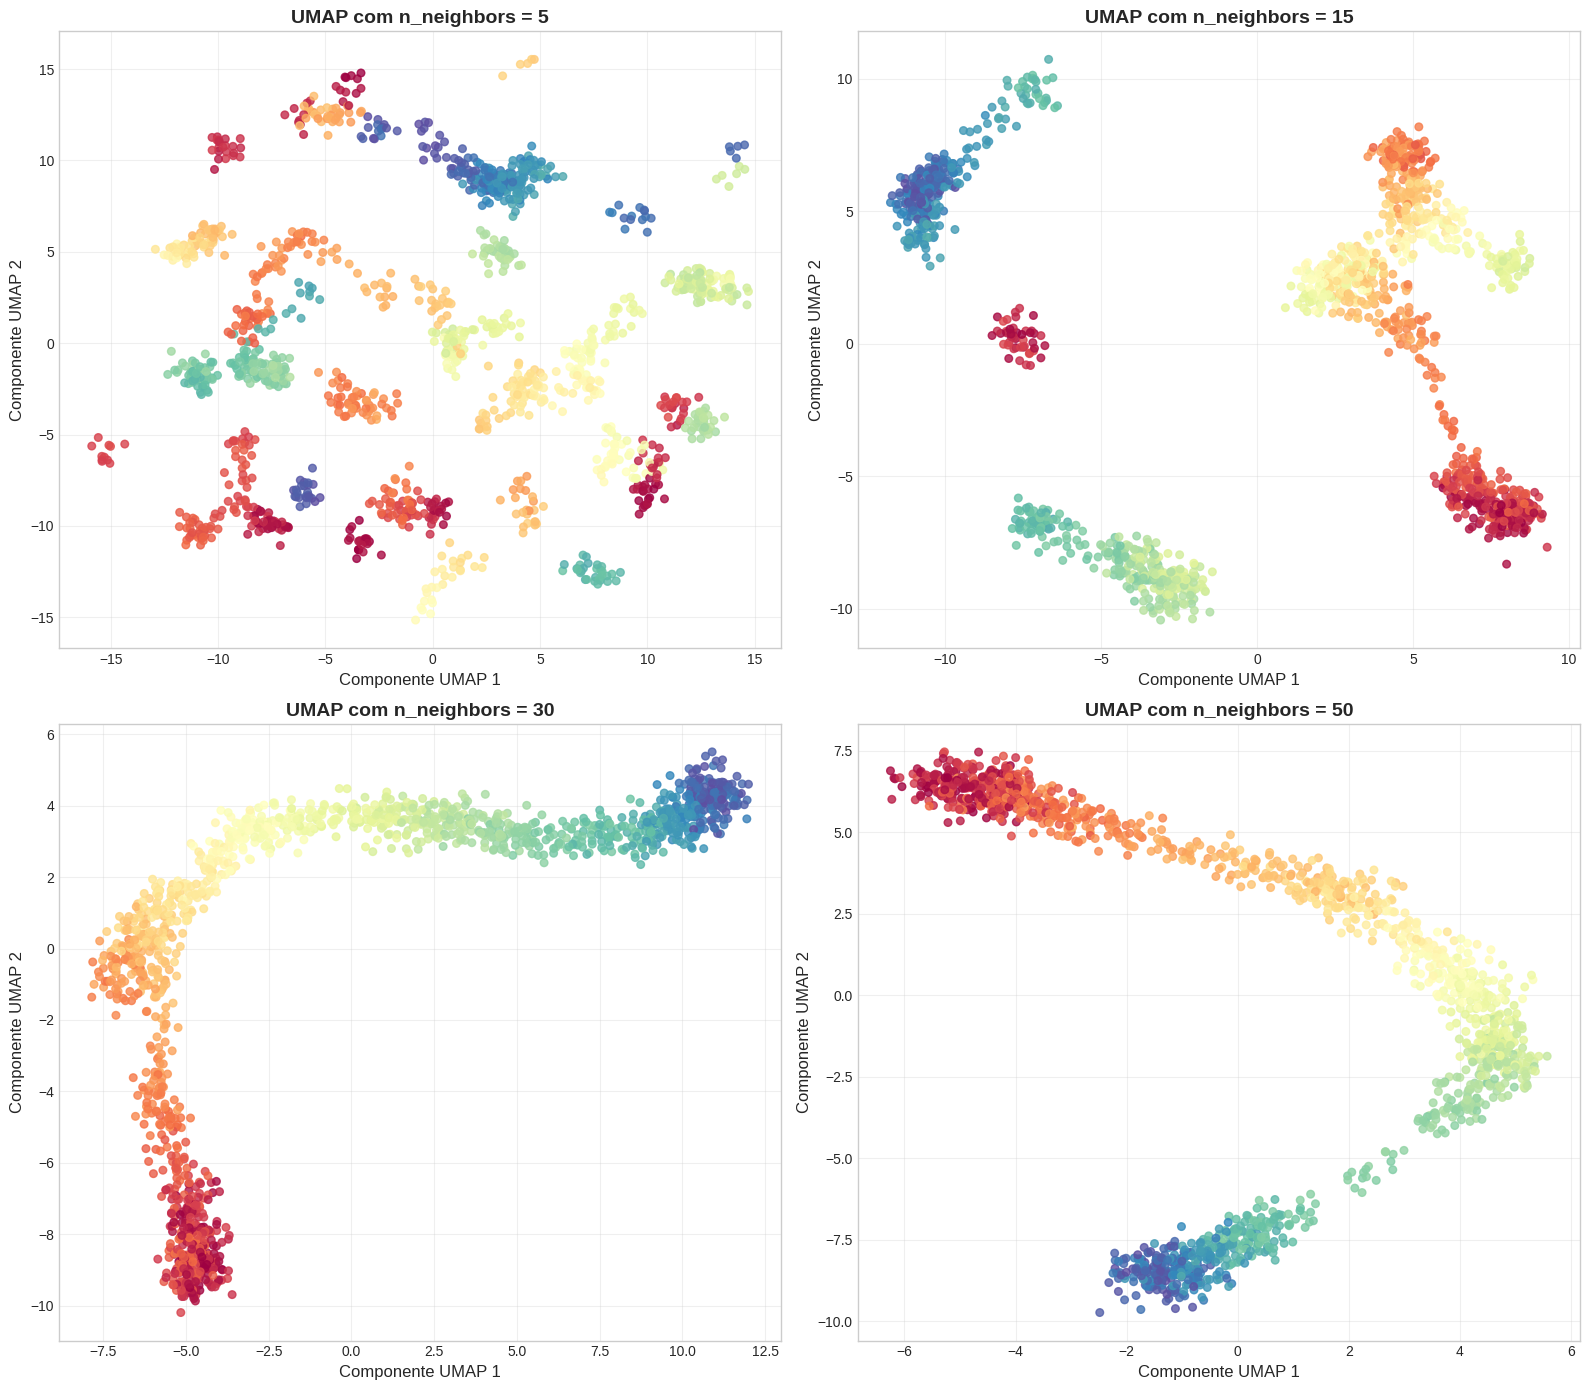

In [4]:
# Testar diferentes valores de n_neighbors
n_neighbors_values = [5, 15, 30, 50]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, n_neigh in enumerate(n_neighbors_values):
    print(f"\n{'='*50}")
    print(f"Treinando UMAP com n_neighbors = {n_neigh}")
    print(f"{'='*50}")
    
    # Treinar UMAP
    umap_model = UMAP(n_neighbors=n_neigh, n_components=2, n_epochs=500, random_state=42)
    embedding_result = umap_model.fit_transform(X)
    
    # Plotar
    ax = axes[idx]
    scatter = ax.scatter(embedding_result[:, 0], embedding_result[:, 1], 
                        c=color, cmap=plt.cm.Spectral, s=30, alpha=0.8)
    
    ax.set_title(f'UMAP com n_neighbors = {n_neigh}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Componente UMAP 1', fontsize=12)
    ax.set_ylabel('Componente UMAP 2', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Análise dos Resultados:**

O parâmetro `n_neighbors` controla o equilíbrio entre estrutura local e global no UMAP:

- **n_neighbors baixo (5)**: Foca mais em estruturas locais, preservando detalhes finos mas potencialmente fragmentando a estrutura global. O embedding pode criar muitos pequenos clusters.

- **n_neighbors moderado (15-30)**: Oferece um bom equilíbrio entre preservação local e global. Este é geralmente o intervalo recomendado, com 15 sendo o valor padrão na biblioteca UMAP.

- **n_neighbors alto (50)**: Enfatiza mais a estrutura global, criando um embedding mais "suave" onde clusters podem se fundir. Útil quando você quer capturar relações de larga escala.

Para o Swiss Roll, valores moderados (15-30) tendem a "desenrolar" melhor o manifold, preservando a progressão contínua das cores.

### Solução Exercício 2: Visualização do MNIST com UMAP

Vamos aplicar o UMAP ao dataset MNIST para visualizar os dígitos manuscritos em um espaço bidimensional.

In [5]:
from sklearn.datasets import fetch_openml

# Carregar o dataset MNIST (vamos usar um subconjunto para performance)
print("Carregando o dataset MNIST...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Usar apenas uma amostra para tornar o processamento viável
n_samples_mnist = 5000
indices = np.random.RandomState(42).choice(len(mnist.data), n_samples_mnist, replace=False)

X_mnist = np.array(mnist.data)[indices]
y_mnist = np.array(mnist.target)[indices].astype(int)

# Normalizar os dados
X_mnist = X_mnist / 255.0

print(f"Dimensões do MNIST (amostra): {X_mnist.shape}")
print(f"Número de dígitos únicos: {len(np.unique(y_mnist))}")

Carregando o dataset MNIST...
Dimensões do MNIST (amostra): (5000, 784)
Número de dígitos únicos: 10


In [6]:
# Treinar UMAP no MNIST
print("\nTreinando UMAP no MNIST...")
print("="*50)

umap_mnist = UMAP(n_neighbors=15, n_components=2, n_epochs=300, random_state=42)
mnist_embedding = umap_mnist.fit_transform(X_mnist)

print("UMAP treinado com sucesso!")


Treinando UMAP no MNIST...
UMAP treinado com sucesso!


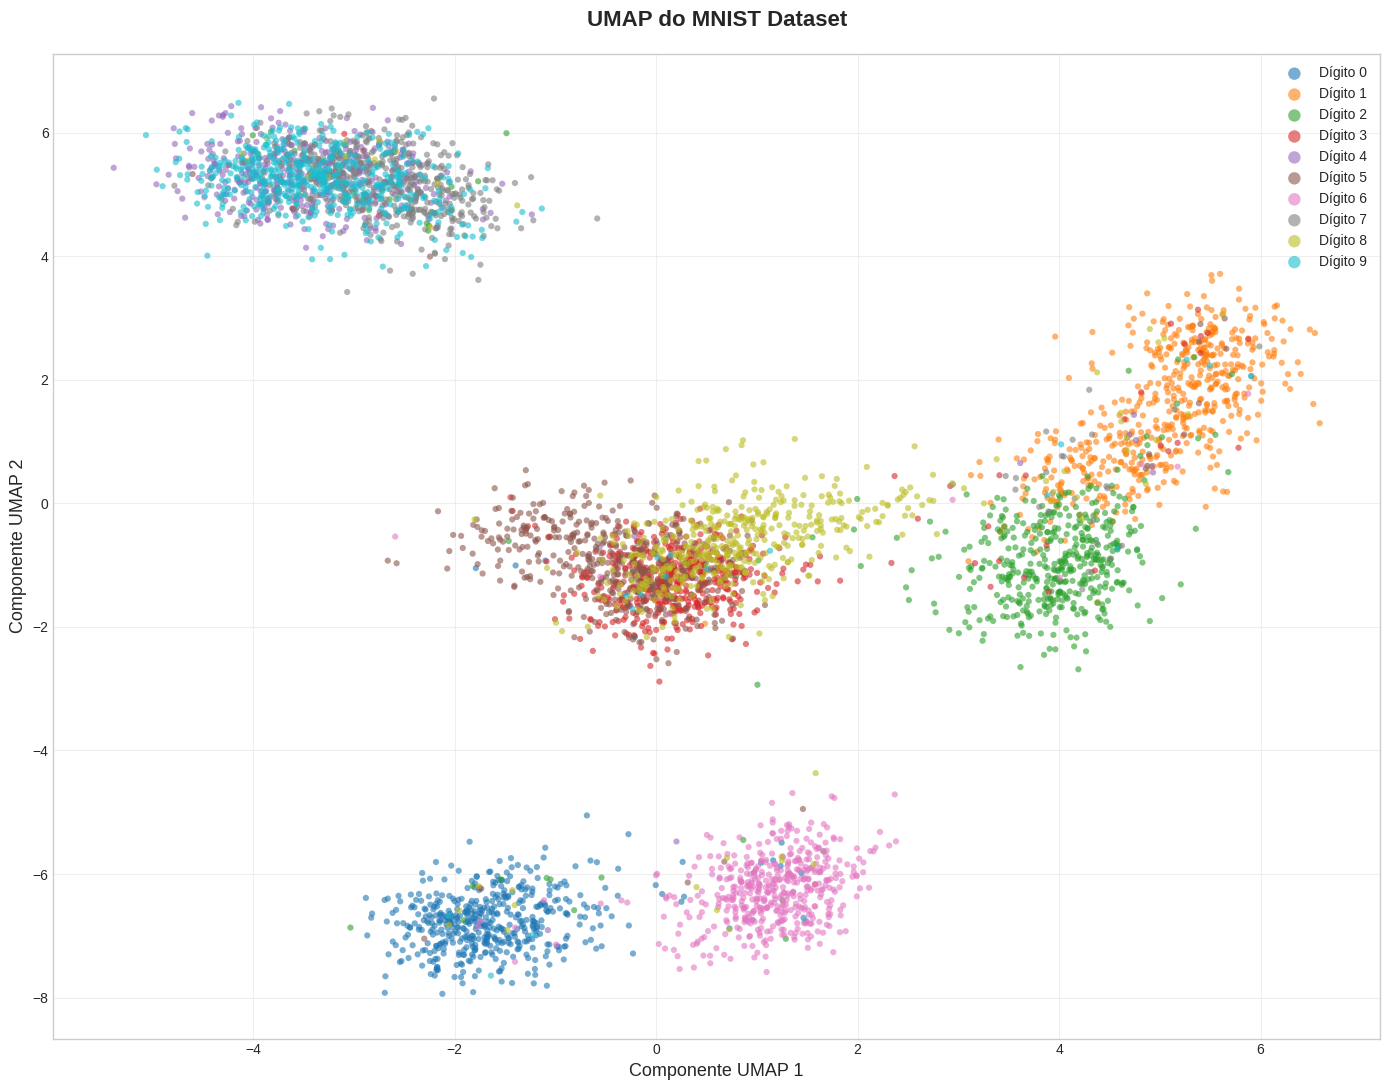

In [7]:
# Visualizar o resultado
plt.figure(figsize=(14, 11))

# Criar um colormap para os 10 dígitos
colors_mnist = plt.cm.tab10(np.linspace(0, 1, 10))

for digit in range(10):
    mask = y_mnist == digit
    plt.scatter(mnist_embedding[mask, 0], 
               mnist_embedding[mask, 1],
               c=[colors_mnist[digit]],
               label=f'Dígito {digit}',
               s=20,
               alpha=0.6,
               edgecolors='none')

plt.title('UMAP do MNIST Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Componente UMAP 1', fontsize=13)
plt.ylabel('Componente UMAP 2', fontsize=13)
plt.legend(loc='best', fontsize=10, markerscale=2, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Análise do Resultado:**

O UMAP conseguiu criar uma visualização impressionante do dataset MNIST:

1. **Separação de Clusters**: Cada dígito (0-9) forma clusters distintos no espaço bidimensional, demonstrando que o UMAP preservou efetivamente a similaridade entre imagens do mesmo dígito.

2. **Estrutura Topológica**: A disposição dos clusters revela relações interessantes entre os dígitos. Por exemplo:
   - Dígitos visualmente similares (como 4 e 9, ou 3 e 8) tendem a estar mais próximos
   - O dígito 1 geralmente forma um cluster bem isolado por ser muito distinto dos outros

3. **Preservação Global e Local**: O UMAP manteve tanto a estrutura de vizinhança local (dígitos similares ficam juntos) quanto relações globais (clusters bem separados).

4. **Vantagens sobre PCA e t-SNE**: 
   - Mais rápido que t-SNE para grandes datasets
   - Preserva melhor a estrutura global que t-SNE
   - Captura relações não-lineares que PCA não consegue

### Comparação: UMAP vs t-SNE vs PCA no MNIST

Para ilustrar as diferenças entre as três técnicas, vamos compará-las lado a lado.

Aplicando PCA...
Aplicando t-SNE...
Todas as técnicas aplicadas!


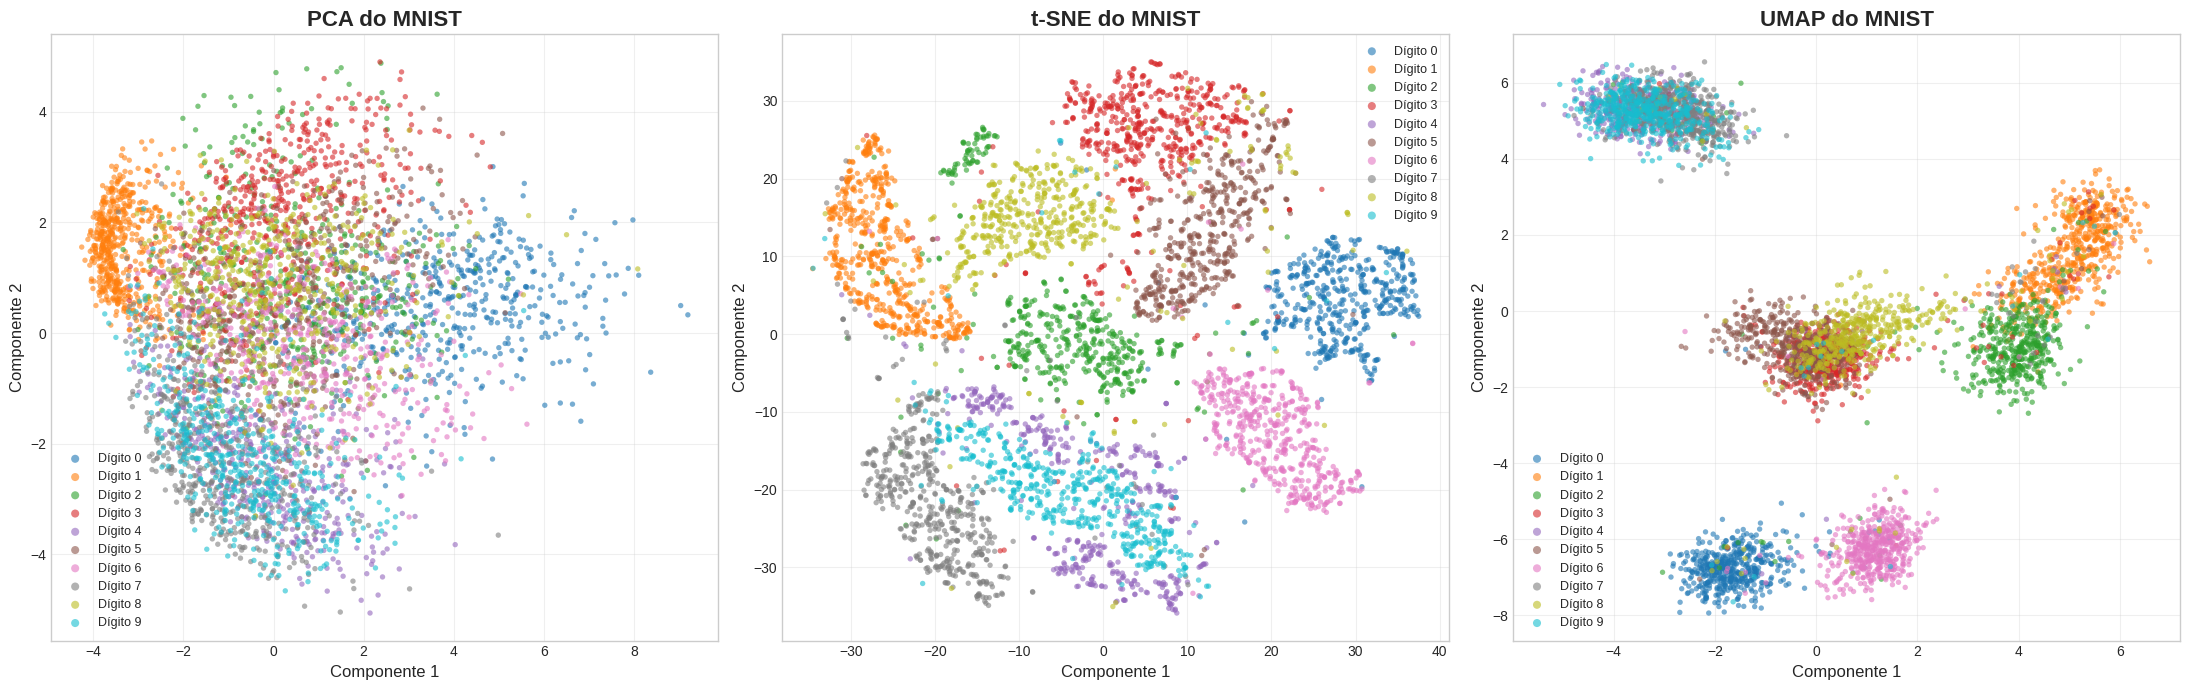


Variância explicada pelo PCA: 16.70%


In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Aplicar PCA
print("Aplicando PCA...")
pca_mnist = PCA(n_components=2, random_state=42)
mnist_pca = pca_mnist.fit_transform(X_mnist)

# Aplicar t-SNE (usando sklearn para comparação justa)
print("Aplicando t-SNE...")
tsne_mnist = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500)
mnist_tsne = tsne_mnist.fit_transform(X_mnist)

print("Todas as técnicas aplicadas!")

# Criar visualização comparativa
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

techniques = [
    (mnist_pca, 'PCA', axes[0]),
    (mnist_tsne, 't-SNE', axes[1]),
    (mnist_embedding, 'UMAP', axes[2])
]

for embedding_data, name, ax in techniques:
    for digit in range(10):
        mask = y_mnist == digit
        ax.scatter(embedding_data[mask, 0], 
                  embedding_data[mask, 1],
                  c=[colors_mnist[digit]],
                  label=f'Dígito {digit}',
                  s=15,
                  alpha=0.6,
                  edgecolors='none')
    
    ax.set_title(f'{name} do MNIST', fontsize=16, fontweight='bold')
    ax.set_xlabel('Componente 1', fontsize=12)
    ax.set_ylabel('Componente 2', fontsize=12)
    ax.legend(loc='best', fontsize=9, markerscale=1.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVariância explicada pelo PCA: {sum(pca_mnist.explained_variance_ratio_):.2%}")